# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline     

from tqdm import tqdm
import torch
import torchvision.models as models

from PIL import Image, ImageFile 
import torchvision.transforms as transforms

import os
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F

import random

# check if CUDA is available
use_cuda = torch.cuda.is_available()


In [2]:
# import numpy as np
# from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [5]:
# import cv2                
# import matplotlib.pyplot as plt                        
# %matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale


In [6]:
type(face_cascade)

print(dog_files[100])

dogImages/valid/024.Bichon_frise/Bichon_frise_01748.jpg


Number of faces detected: 1


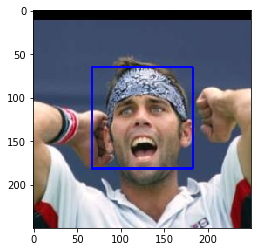

In [7]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__  

99.00% in sample human dataset is classified as human face.

12.00% in sample dog dataset is classified as human face.


In [9]:
# from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
faces_vfunc = np.vectorize(face_detector)

human_faces = faces_vfunc(human_files_short)
dog_faces = faces_vfunc(dog_files_short)

# Calculate and print percentage of faces in each set
print(' {:.2f}% in sample human dataset is classified as human face.'.format((sum(human_faces)/len(human_faces))*100))
print(' {:.2f}% in sample dog dataset is classified as human face.'.format((sum(dog_faces)/len(dog_faces))*100))
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.


 99.00% in sample human dataset is classified as human face.
 12.00% in sample dog dataset is classified as human face.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [11]:
# import torch
# import torchvision.models as models
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
# use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    print("Using the GPU for processing.")
else:
    print("Using the GPU for processing.")

Using the GPU for processing.


In [47]:
# The layers in VGG16 was
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [13]:
#from torch.autograd import Variable
# from PIL import Image, ImageFile 
# import torchvision.transforms as transforms


def convertImageToTensor(image):
    '''The vgg16 requires the images to be normalized . so converting it to the required form.'''
    
    transformToVGGTensors = transforms.Compose([transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    
    img = Image.open( image ).convert('RGB')
    img_tensor = transformToVGGTensors( img )[:3,:,:].unsqueeze(0)
    return img_tensor


def image_convert(tensor):
    """ Retun tensor as img . Taken from the style transfer excersise"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Normal image:


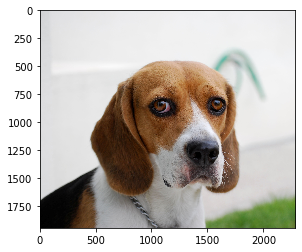

After conversion: torch.Size([1, 3, 224, 224])


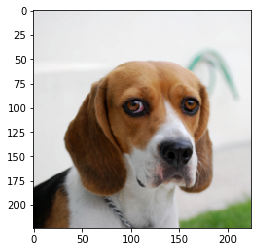

In [49]:
# Testing if the conversion is working
print("Normal image:")
img = Image.open(dog_files[1])
plt.imshow(img)
plt.show()


imgTensor = convertImageToTensor(dog_files[1])

plt.imshow(image_convert(imgTensor))
print("After conversion:",imgTensor.shape)


In [15]:
# Set PIL to be tolerant of image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    img_tensor = convertImageToTensor(img_path)
    VGG16.eval() # Make the model in evaluation mode
    
    # if GPU available, move model inputs to GPU
    if use_cuda:
        img_tensor = img_tensor.cuda()
            
    # get sample outputs
    output = VGG16(img_tensor)
    
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)    
    index = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    return int(index) # predicted class index

In [16]:
# Check if the model is returing some index values. 
# Its note sure that it can be the index of the image which shows as the cat.
print("predicted class id : ", VGG16_predict( dog_files[1] ))

predicted class id :  162


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [17]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    return (index <= 268) & (151 <= index) # true/false

In [18]:
# Check if the dog file is classified as dog itself. Returns true if truly classified as dog
print("The dog image is classified as   :",dog_detector(dog_files[1]))
print("The human iamge is classified as :",dog_detector(human_files[1]))


The dog image is classified as   : True
The human iamge is classified as : False


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__

Among first 100 images of humans 0% is detected as dogs.

Among first 100 images of dogs   99% is detected as dogs.


In [19]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
humansClassifiedAsDogs = sum([dog_detector(image) for image in human_files_short])
dogsClassifiedAsDogs = sum([dog_detector(image) for image in dog_files_short])

print("Among first 100 images of humans {}% is detected as dogs".format(humansClassifiedAsDogs))
print("Among first 100 images of dogs   {}% is detected as dogs".format(dogsClassifiedAsDogs))


Among first 100 images of humans 0% is detected as dogs
Among first 100 images of dogs   99% is detected as dogs


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [20]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [44]:
# import os
# from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

print("Manually spliting the images into  ")
# define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder('dogImages/train', transform=train_transforms)
test_data = datasets.ImageFolder('dogImages/test', transform=test_transforms)
valid_data = datasets.ImageFolder('dogImages/valid', transform=test_transforms)

#  Display the loaded data counts
print('\t Count of training set   : ',len(train_data))
print('\t Count of test set       : ',len(test_data))
print('\t Count of validation set :',len(valid_data))


trainloader = torch.utils.data.DataLoader( train_data, batch_size=32, shuffle=True )
testloader = torch.utils.data.DataLoader( test_data, batch_size=16 )
validloader = torch.utils.data.DataLoader( valid_data, batch_size=16 )

# Change it to dictionary
loaders_scratch = {}
loaders_scratch['train'] = trainloader
loaders_scratch['valid'] = validloader
loaders_scratch['test'] = testloader

print("Completed the splitting")



Manually spliting the images into  
	 Count of training set   :  6680
	 Count of test set       :  836
	 Count of validation set : 835
Completed the splitting


In [51]:

class_names = train_data.classes
number_classes = len(class_names)

# correct output-size of the CNN
param_output_size = len(class_names)

print("number of classes:", number_classes)
print("\nFIrst four class names: \n", class_names[:4])

number of classes: 133

FIrst four class names: 
 ['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita']


/home/vyshak/anaconda3/envs/nanodegree/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


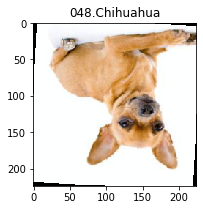

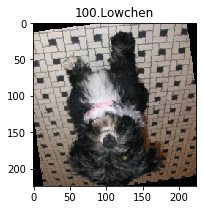

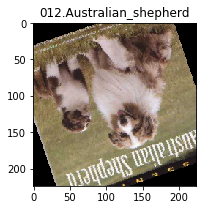

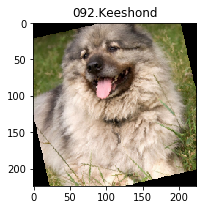

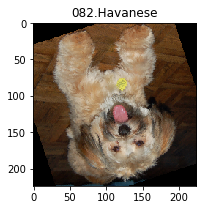

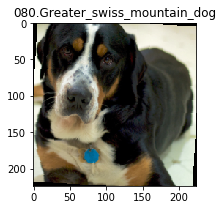

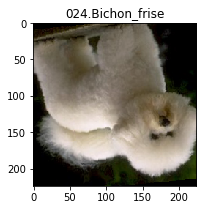

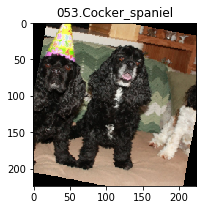

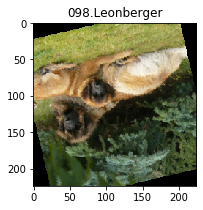

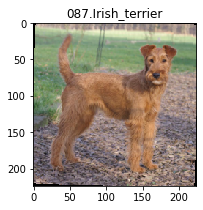

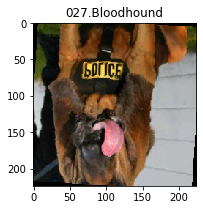

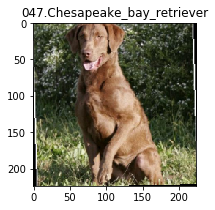

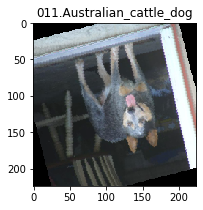

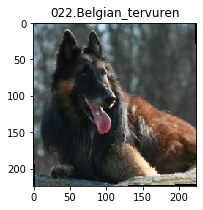

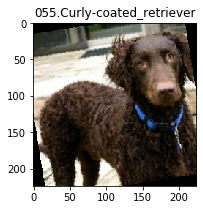

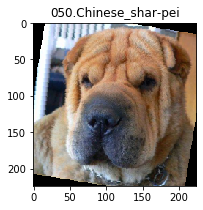

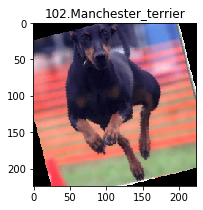

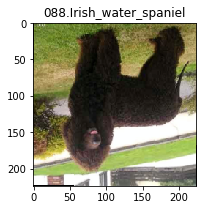

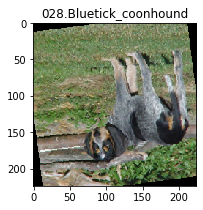

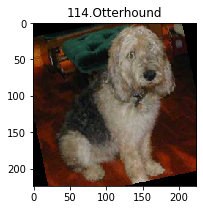

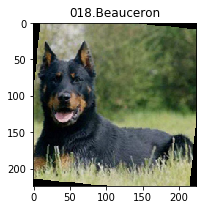

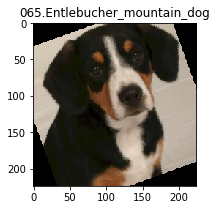

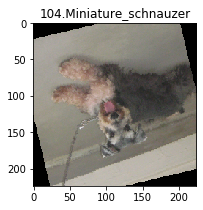

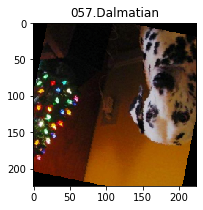

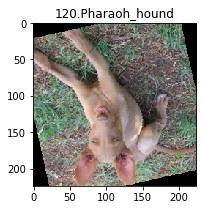

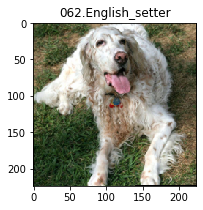

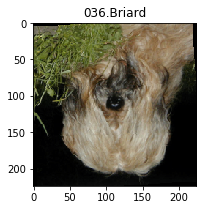

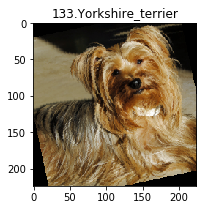

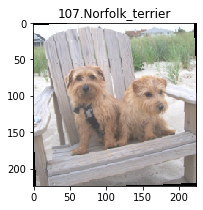

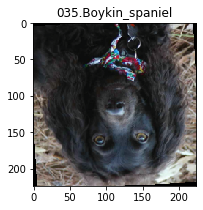

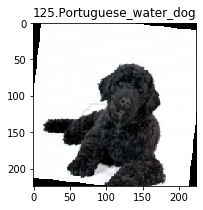

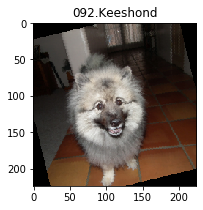

In [23]:
# test train loaders to see how it looks like
# get a batch of training datas
inputs, classes = next( iter(loaders_scratch['train']) )

for image, label in zip(inputs, classes): 
    image = image.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    # normalize image
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
     
    fig = plt.figure(figsize=(12,3))
    plt.imshow(image)
    plt.title(class_names[label])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

The data was loaded and splitted into train, test and validation set by using the Dataloader in torch.utils.data.
I resized the image to 224 so that it can be used for VGG model.

Also done random rotations also.
The input to VGG model has to be 224x224 pixel images .  So I choose it as the size for all models.
Also data was normalized with mean [0.485, 0.456, 0.406] and the standard deviation are [0.229, 0.224, 0.225].

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [55]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        print("create model ... ")
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (sees 28x28x64 -> 500)
        self.fc1 = nn.Linear(28 * 28 * 64, 500)
        # linear layer (500 -> 133)
        self.fc2 = nn.Linear(500, param_output_size)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.batch_norm = nn.BatchNorm1d(num_features=500)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten image input --> 28 * 28 * 64 = 50176
        x = x.view(x.size(0), -1)
        # dropout layer
        x = self.dropout(x)
        # 1st hidden layer, with relu
        x = F.relu(self.batch_norm( self.fc1(x)) )
        # dropout layer
        x = self.dropout(x)
        # 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

create model ... 
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

The input size of the image was (224, 224, 3) and have 133 classes in last layer.

I stacked three convolutional layers then a maxpooling layer then linear layer . To avoid overfillting the dropout
layer was aldo added. The final result will be of 133 class.

To extract features , I used convolutional layers. 
To down size the sample I used the maxpooling  layer.


The first layer in the CNN is a convolutional layer that takes (224, 224, 3) input size.

The stide was given as 1.
Also give pading so that all the pixels will be learned.
_nn.Conv2d(in_channels, out_channels, kernelsize, stride=1, padding=0)

The pooling layer helps to down sample the dimension by the factor of 2.
And finally added a fully connected network.
The reult will be any of the classes in 133 classes.

Used bachnormalization for weight updation in backpropogation.

The model is of the form : 
```
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
```

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [25]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [26]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    print("start training for {} epochs ...".format(n_epochs))
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    # exist save-file, load save file
    if os.path.exists(save_path):
        print("load previous saved model ...")
        model.load_state_dict(torch.load(save_path))
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        mn = 0
        print("epoch : ",epoch)
        
        # train the model 
        model.train()    # --- set model to train mode
        for batch_idx, (data, target) in enumerate(loaders['train']):
            print("epoch : ",epoch,"Train : ", mn)
            mn = mn+1
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # -----------------------------
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item()*data.size(0)
            # -----------------------------
            
        # validate the model 
        model.eval()        # ---- set model to evaluation mode
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # -----------------------------
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item() * data.size(0)
            # -----------------------------
            
        # calculate average losses
        train_loss = train_loss / len(loaders['train'].dataset)
        valid_loss = valid_loss / len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format( epoch, train_loss, valid_loss ),end="")
        
        ## TODO: save the model if validation loss has decreased
        # -----------------------------
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            print('  Saving model ...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        else:
            print("")
        # -----------------------------
    
    print("done")
    # return trained model
    return model


# train the model
# Uncomment this line to train the model
# model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
#                       criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [29]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    i=0
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        print("Training : ",i)
        i = i+1
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Training :  0
Training :  1
Training :  2
Training :  3
Training :  4
Training :  5
Training :  6
Training :  7
Training :  8
Training :  9
Training :  10
Training :  11
Training :  12
Training :  13
Training :  14
Training :  15
Training :  16
Training :  17
Training :  18
Training :  19
Training :  20
Training :  21
Training :  22
Training :  23
Training :  24
Training :  25
Training :  26
Training :  27
Training :  28
Training :  29
Training :  30
Training :  31
Training :  32
Training :  33
Training :  34
Training :  35
Training :  36
Training :  37
Training :  38
Training :  39
Training :  40
Training :  41
Training :  42
Training :  43
Training :  44
Training :  45
Training :  46
Training :  47
Training :  48
Training :  49
Training :  50
Training :  51
Training :  52
Test Loss: 3.580748


Test Accuracy: 16% (141/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [30]:
## TODO: Specify data loaders
# use the same data loaders
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [56]:
# import torchvision.models as models
# import torch.nn as nn

## TODO: Specify model architecture 

model_transfer = models.vgg19(pretrained=True)
if use_cuda:
    model_transfer = model_transfer.cuda()
    print("Using CUDA for training.")
    
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The ImageNet data was trained with high computational resource and have an optimzed weights. So by using the 
pretrained VGG model , I only want to remove the final layer to add the classes that my problem requires.
I can also fine tune the previous layer if required. But it was not done here.



The classifier part of the VGG19 model is a single fully-connected layer: and it has 1000 class as output.
classifier[6]: (6): Linear(in_features=4096, out_features=1000, bias=True)

I also set the parameters of the VGG model to not be trainable again. 
As the ImageNet data were images, and almost all the architectures base layers will figureout the features in the same manner. So for this situation the VGG architecture was enough.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [32]:
# this is needed for pre-trained networks
# freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False

# replace the last fully connected layer with a Linnear layer with 133 out features (param_output_size)
model_transfer.classifier[6] = nn.Linear(4096, param_output_size, bias=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [33]:
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(filter(lambda p: p.requires_grad,model_transfer.parameters()), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [34]:
# train the model
param_epochs = 2
# uncomment to train it again
# model_transfer = train(param_epochs, loaders_transfer, model_transfer, optimizer_transfer, 
#                        criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
#model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=lambda storage, location: 'cpu'))

start training for 1 epochs ...
epoch :  1
epoch :  1 Train :  0
epoch :  1 Train :  1
epoch :  1 Train :  2
epoch :  1 Train :  3
epoch :  1 Train :  4
epoch :  1 Train :  5
epoch :  1 Train :  6
epoch :  1 Train :  7
epoch :  1 Train :  8
epoch :  1 Train :  9
epoch :  1 Train :  10
epoch :  1 Train :  11
epoch :  1 Train :  12
epoch :  1 Train :  13
epoch :  1 Train :  14
epoch :  1 Train :  15
epoch :  1 Train :  16
epoch :  1 Train :  17
epoch :  1 Train :  18
epoch :  1 Train :  19
epoch :  1 Train :  20
epoch :  1 Train :  21
epoch :  1 Train :  22
epoch :  1 Train :  23
epoch :  1 Train :  24
epoch :  1 Train :  25
epoch :  1 Train :  26
epoch :  1 Train :  27
epoch :  1 Train :  28
epoch :  1 Train :  29
epoch :  1 Train :  30
epoch :  1 Train :  31
epoch :  1 Train :  32
epoch :  1 Train :  33
epoch :  1 Train :  34
epoch :  1 Train :  35
epoch :  1 Train :  36
epoch :  1 Train :  37
epoch :  1 Train :  38
epoch :  1 Train :  39
epoch :  1 Train :  40
epoch :  1 Train :  41
e

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [35]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Training :  0
Training :  1
Training :  2
Training :  3
Training :  4
Training :  5
Training :  6
Training :  7
Training :  8
Training :  9
Training :  10
Training :  11
Training :  12
Training :  13
Training :  14
Training :  15
Training :  16
Training :  17
Training :  18
Training :  19
Training :  20
Training :  21
Training :  22
Training :  23
Training :  24
Training :  25
Training :  26
Training :  27
Training :  28
Training :  29
Training :  30
Training :  31
Training :  32
Training :  33
Training :  34
Training :  35
Training :  36
Training :  37
Training :  38
Training :  39
Training :  40
Training :  41
Training :  42
Training :  43
Training :  44
Training :  45
Training :  46
Training :  47
Training :  48
Training :  49
Training :  50
Training :  51
Training :  52
Test Loss: 1.381584


Test Accuracy: 71% (596/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [36]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = convertImageToTensor(img_path)

    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]


def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()

In [57]:
# Some testing
for image in random.sample(list(human_files_short), 4): 
    predicted_breed = predict_breed_transfer(image)
    display_image(image, title="Predicted: {}".format(predicted_breed) )

IndexError: list index out of range

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [39]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    # check if image has juman faces:
    if (face_detector(img_path)):
        print("Hello Human!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title="Predicted: {}".format(predicted_breed) )
        
        print("You look like a ...")
        print(predicted_breed)
        
    # check if image has dogs:
    elif dog_detector(img_path):
        print("Hello Dog!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title="Predicted: {}".format(predicted_breed) )
        
        print("Your breed is most likley ...")
        print(predicted_breed)
    # otherwise
    else:
        print("Oh, we're sorry! We couldn't detect any dog or human face in the image.")
        display_image(img_path, title="...")
        print("Try another!")
        
    print("\n")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

Hello Human!


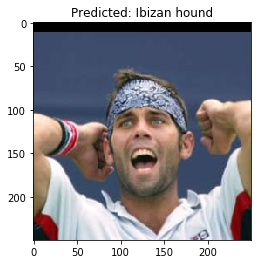

You look like a ...
Ibizan hound


Hello Human!


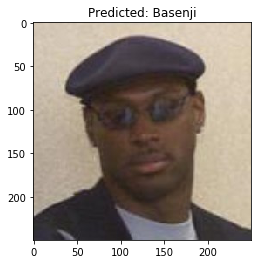

You look like a ...
Basenji


Hello Human!


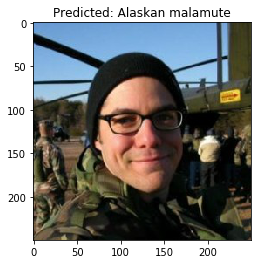

You look like a ...
Alaskan malamute


Hello Dog!


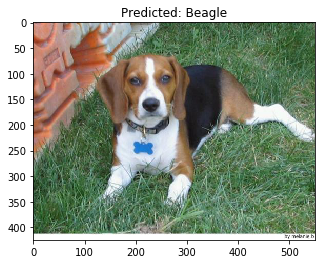

Your breed is most likley ...
Beagle


Hello Dog!


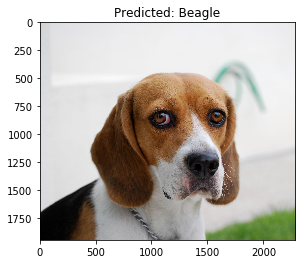

Your breed is most likley ...
Beagle


Hello Dog!


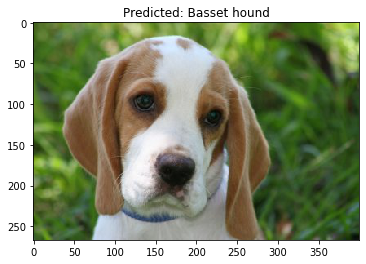

Your breed is most likley ...
Basset hound




In [40]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)